This notebook recapitulates the scrnaseq analysis performed by cohen, using their notebook code where possible, with the aim of producing a list of cell-type calls and filtered lists.

First, we need to get their data.

In [5]:
import urllib.request
import subprocess
data_root="/home/mcn26/palmer_scratch/tabula_data"

In [9]:
urllib.request.urlretrieve("https://zenodo.org/records/14907846/files/scMPRA.zip?download=1",f"{data_root}/dl")

('/home/mcn26/palmer_scratch/tabula_data/dl',
 <http.client.HTTPMessage at 0x151125a61be0>)

In [13]:
subprocess.run(["file",f"{data_root}/dl"])

/home/mcn26/palmer_scratch/tabula_data/dl: Zip archive data, at least v2.0 to extract


CompletedProcess(args=['file', '/home/mcn26/palmer_scratch/tabula_data/dl'], returncode=0)

In [16]:
subprocess.run(["unzip","-d",data_root,f"{data_root}/dl"])

Archive:  /home/mcn26/palmer_scratch/tabula_data/dl
   creating: /home/mcn26/palmer_scratch/tabula_data/scMPRA/
  inflating: /home/mcn26/palmer_scratch/tabula_data/__MACOSX/._scMPRA  
 extracting: /home/mcn26/palmer_scratch/tabula_data/scMPRA/.Rhistory  
  inflating: /home/mcn26/palmer_scratch/tabula_data/scMPRA/mascot.yml  
  inflating: /home/mcn26/palmer_scratch/tabula_data/scMPRA/.DS_Store  
  inflating: /home/mcn26/palmer_scratch/tabula_data/__MACOSX/scMPRA/._.DS_Store  
  inflating: /home/mcn26/palmer_scratch/tabula_data/scMPRA/readme.md  
  inflating: /home/mcn26/palmer_scratch/tabula_data/__MACOSX/scMPRA/._readme.md  
  inflating: /home/mcn26/palmer_scratch/tabula_data/scMPRA/.RData  
   creating: /home/mcn26/palmer_scratch/tabula_data/scMPRA/scripts/
   creating: /home/mcn26/palmer_scratch/tabula_data/scMPRA/data/
   creating: /home/mcn26/palmer_scratch/tabula_data/scMPRA/notebooks/
  inflating: /home/mcn26/palmer_scratch/tabula_data/scMPRA/scripts/sc_crs_exp.py  
  inflating: 

CompletedProcess(args=['unzip', '-d', '/home/mcn26/palmer_scratch/tabula_data', '/home/mcn26/palmer_scratch/tabula_data/dl'], returncode=0)

In [2]:
subprocess.run(["rm",f"{data_root}/dl"])

CompletedProcess(args=['rm', '/home/mcn26/palmer_scratch/tabula_data/dl'], returncode=0)

Code below adapted from cohen zenodo, `Part1_section3_analyze_scTranscriptome_for_retina.ipynb`.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==2.1.3 scipy==1.15.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 pynndescent==0.5.13


In [6]:
zenodo_root=f"{data_root}/scMPRA"
zenodo_root

'/home/mcn26/palmer_scratch/tabula_data/scMPRA'

In [7]:
adata_1 = sc.read_10x_mtx(
    f'{zenodo_root}/data/sc_transcriptome_data/retina_matrix_r1/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)  

adata_2 = sc.read_10x_mtx(
    f'{zenodo_root}/data/sc_transcriptome_data/retina_matrix_r2/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)

... reading from cache file cache/home-mcn26-palmer_scratch-tabula_data-scMPRA-data-sc_transcriptome_data-retina_matrix_r1-matrix.h5ad
... reading from cache file cache/home-mcn26-palmer_scratch-tabula_data-scMPRA-data-sc_transcriptome_data-retina_matrix_r2-matrix.h5ad


In [8]:
adata= adata_1.concatenate(adata_2, batch_key='sample')

/tmp/tmp.CCs93SE75a/ipykernel_263741/2756604280.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata= adata_1.concatenate(adata_2, batch_key='sample')


In [9]:
adata.var_names_make_unique()

In [12]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 4 cells that have less than 200 genes expressed
filtered out 12101 genes that are detected in less than 3 cells


In [13]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Seems as though they never filtered on mitochondrial, total_counts, but rather just regressed the effects out.

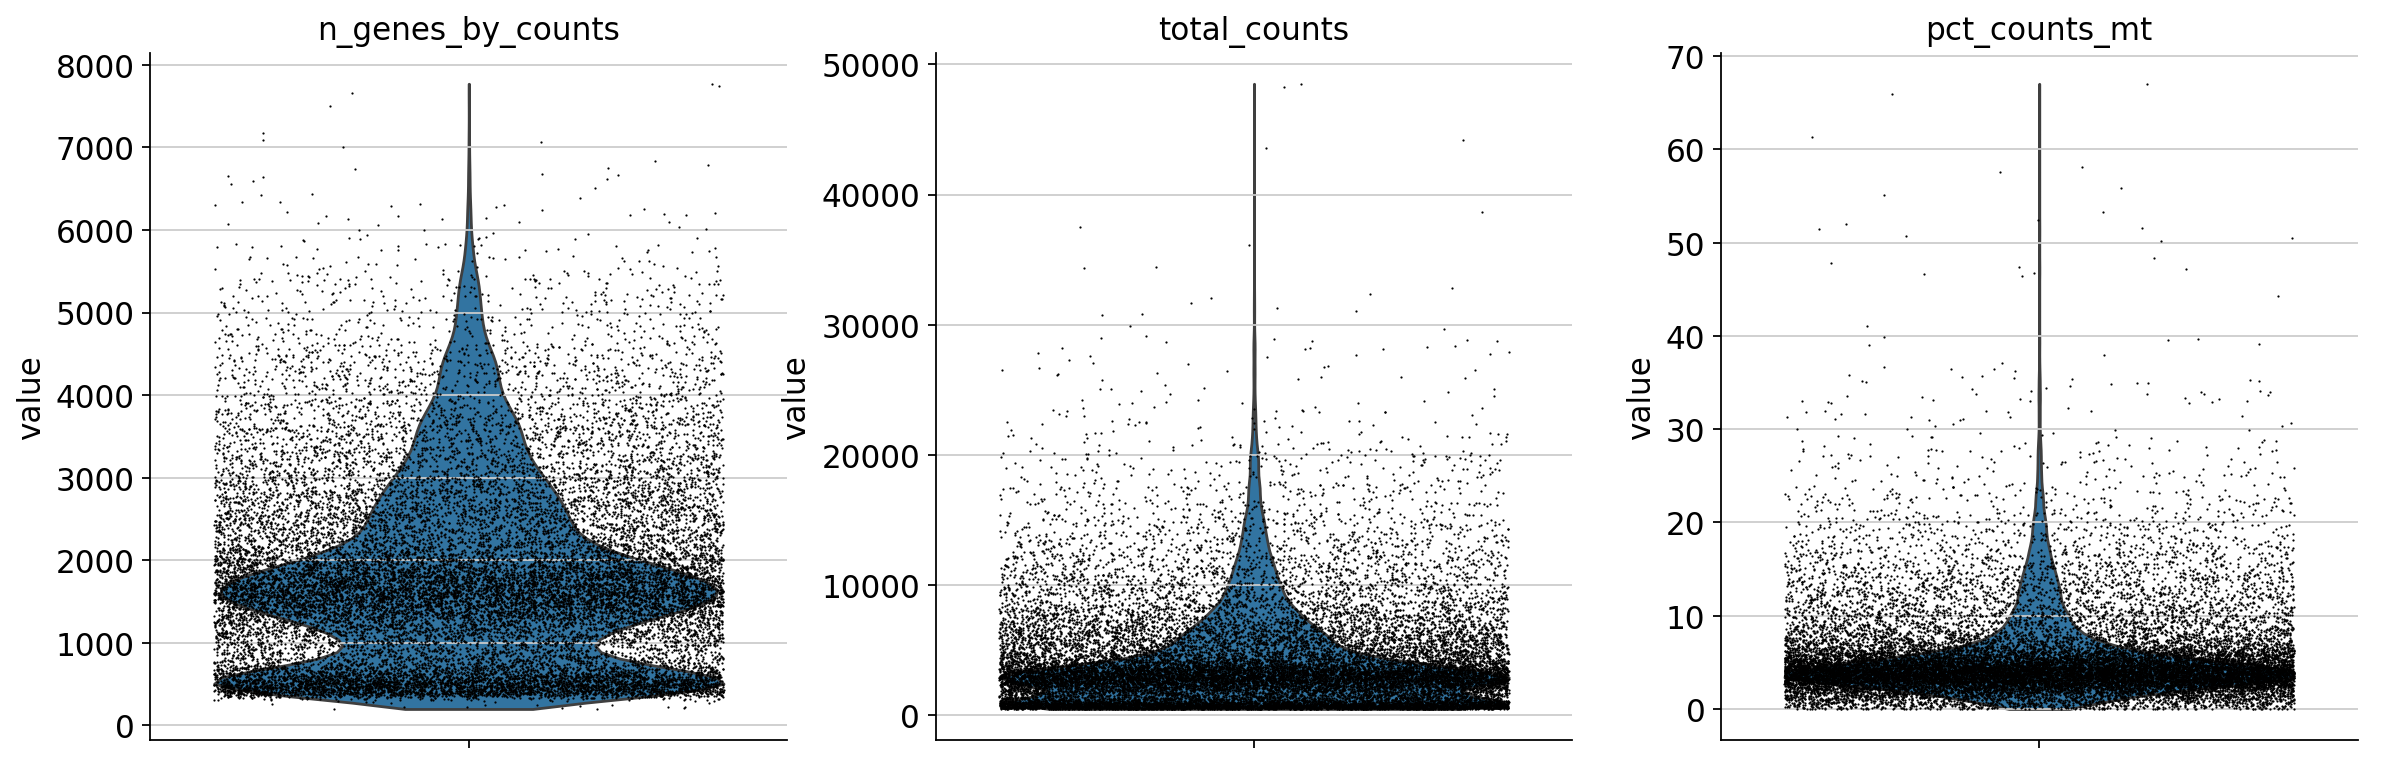

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

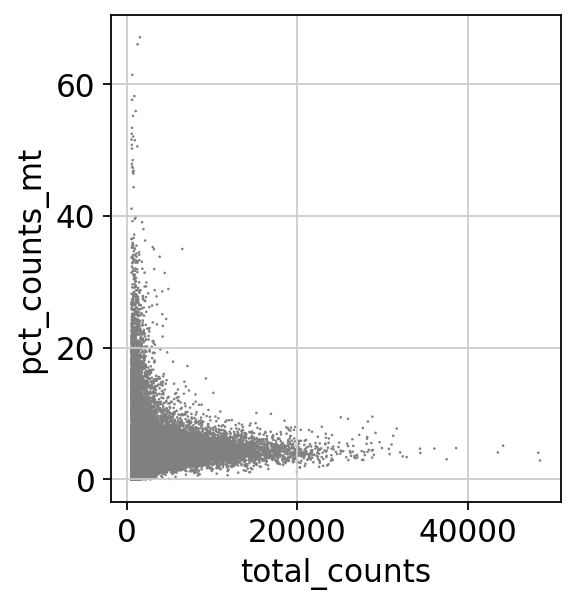

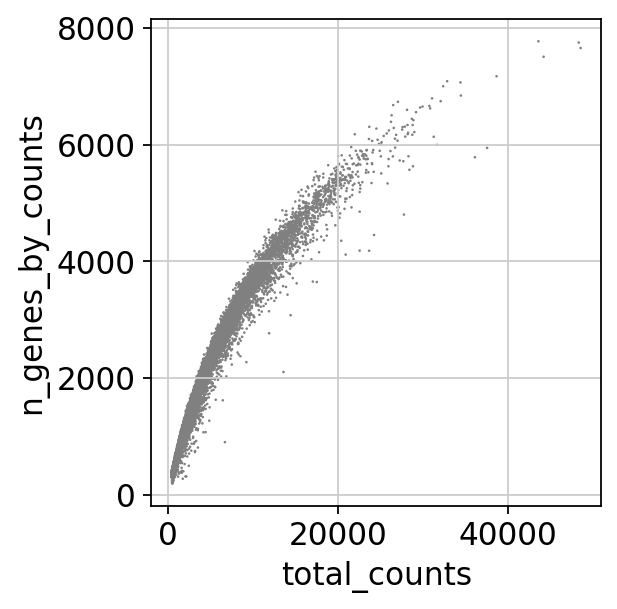

In [15]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [16]:
sc.pp.normalize_total(adata, exclude_highly_expressed=True, target_sum=1e6)

normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['Cst3', 'Fabp5', 'Spp1', 'Apoe', 'Gm42418', 'Malat1', 'Fth1', 'Tmsb4x', 'mt-Nd1', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3', 'mt-Cytb', 'DSRED']
    finished (0:00:00)


In [17]:
sc.pp.log1p(adata)

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=15, min_disp=0.2)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


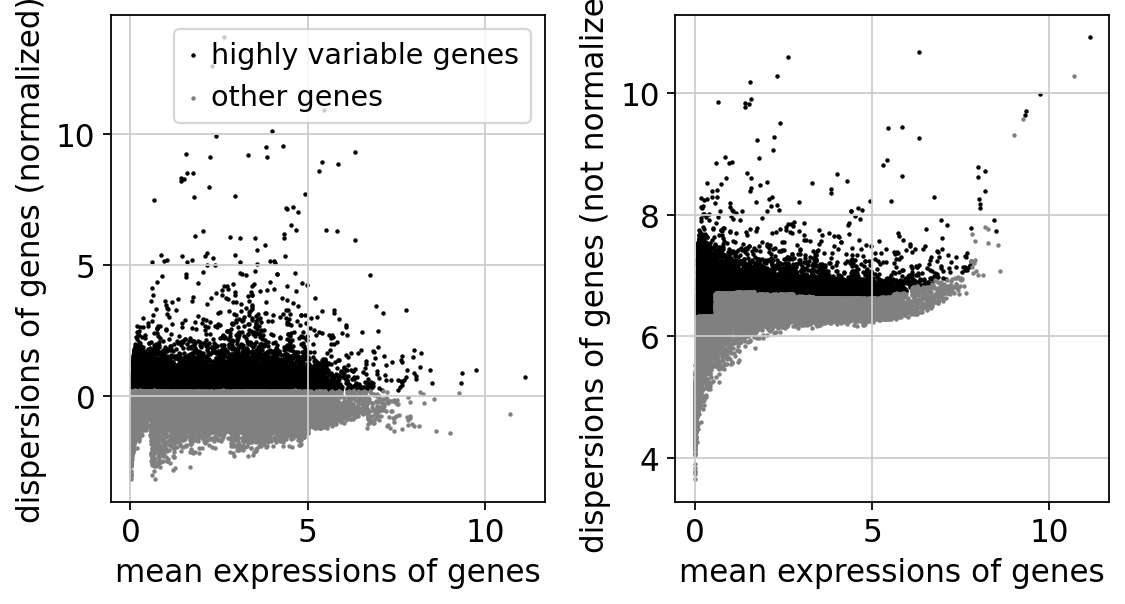

In [19]:
sc.pl.highly_variable_genes(adata)

In [20]:
adata.raw = adata

In [21]:
adata = adata[:, adata.var.highly_variable]

In [22]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']


/home/mcn26/.conda/envs/biopython/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    sparse input is densified and may lead to high memory use
    finished (0:01:50)


In [23]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:01:20)


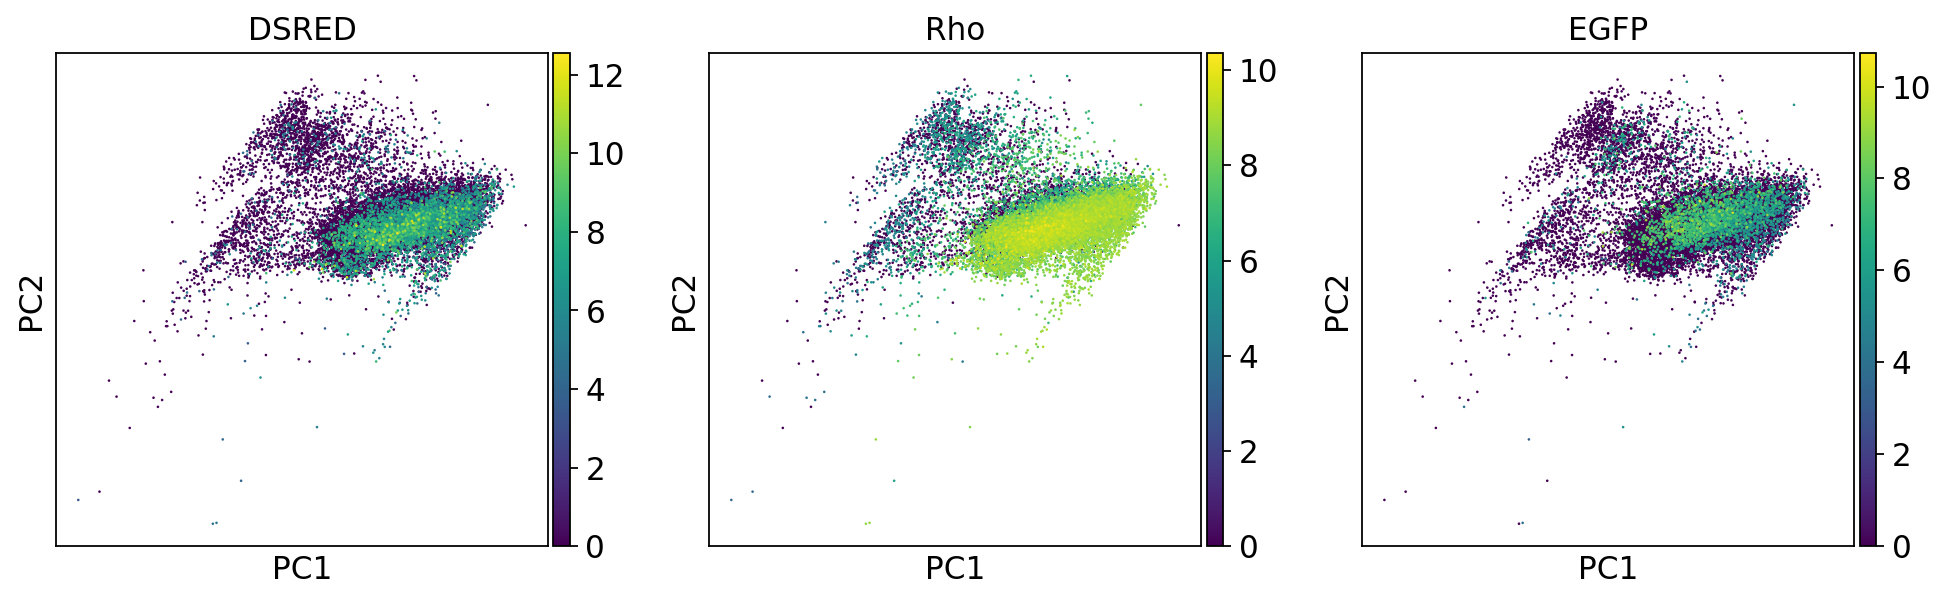

In [24]:
sc.pl.pca(adata, color = ['DSRED', 'Rho', 'EGFP'])

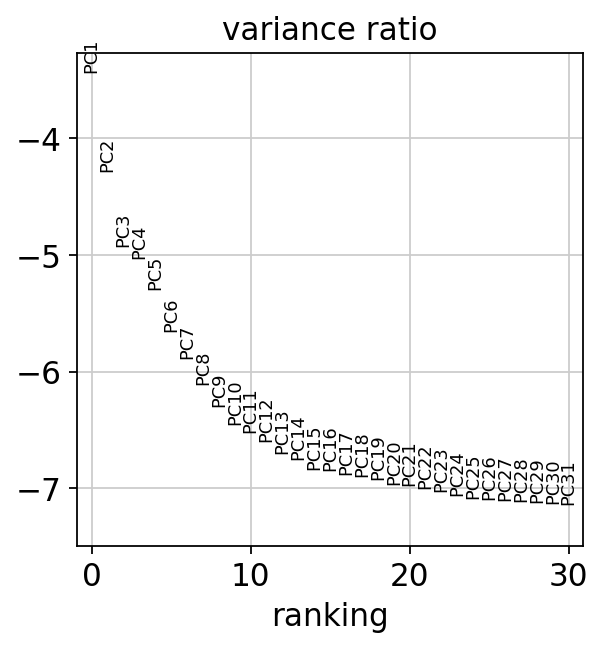

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

In [26]:
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=31)

computing neighbors
    using 'X_pca' with n_pcs = 31
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)


In [27]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:22)


In [30]:
sc.tl.leiden(adata, resolution = 0.06, random_state=1)

running Leiden clustering


/tmp/tmp.CCs93SE75a/ipykernel_263741/3413478702.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.06, random_state=1)


    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


In [31]:
adata.obs.leiden.value_counts()

leiden
0    19349
1     1162
2      871
3      775
Name: count, dtype: int64

These cluster cell counts are identical to the results obtained in the original paper, which makes me confident in their assignment.

In [32]:
new_cluster_names = [
    'Rod', 'Interneuron',
    'Mueller Glia', 'Bipolar']

In [33]:
adata.rename_categories('leiden', new_cluster_names)

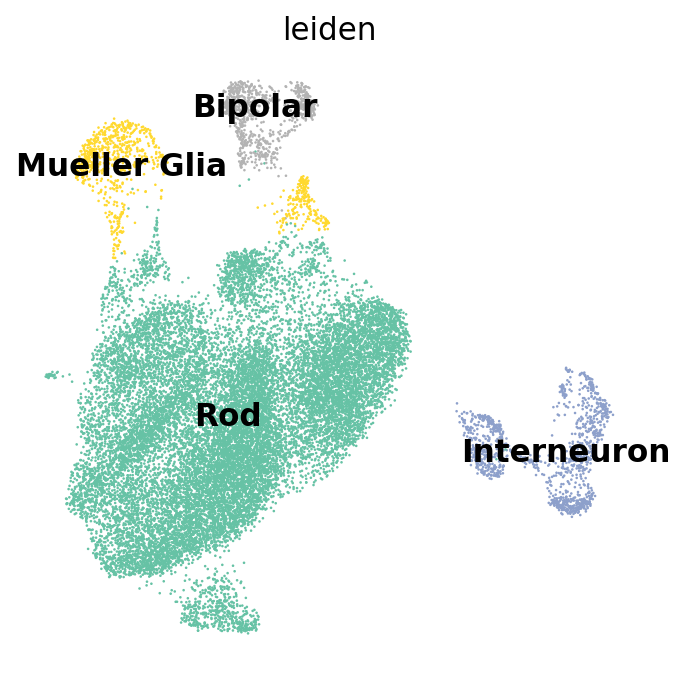

In [34]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color= 'leiden', legend_loc='on data', frameon=False, palette= 'Set2',  show=False)
    #plt.savefig('220525_retina_cells.pdf', dpi = 300)

Perfect. Let's dump the cell IDs that passed QC and their corresponding cluster identities. 

In [53]:
ret=pd.DataFrame(adata.obs['leiden']).reset_index()
ret

,index,leiden
0,AAACCCAAGACAAGCC-1-0,Rod
1,AAACCCAAGAGATCGC-1-0,Rod
2,AAACCCAAGCTGAAAT-1-0,Rod
3,AAACCCAAGTACGTCT-1-0,Rod
4,AAACCCACAACCCGCA-1-0,Rod
...,...,...
22152,TTTGTTGGTTTACCAG-1-1,Rod
22153,TTTGTTGTCACCACAA-1-1,Rod
22154,TTTGTTGTCGGCAGTC-1-1,Rod
22155,TTTGTTGTCGTTAGAC-1-1,Interneuron


In [54]:
ret.rename({'index':'cbc'},axis=1,inplace=True)

In [56]:
ret['replicate']=ret['cbc'].apply(lambda x:x.split("-")[2])
ret['cbc']=ret['cbc'].apply(lambda x:x.split("-")[0])

In [57]:
ret

,cbc,leiden,replicate
0,AAACCCAAGACAAGCC,Rod,0
1,AAACCCAAGAGATCGC,Rod,0
2,AAACCCAAGCTGAAAT,Rod,0
3,AAACCCAAGTACGTCT,Rod,0
4,AAACCCACAACCCGCA,Rod,0
...,...,...,...
22152,TTTGTTGGTTTACCAG,Rod,1
22153,TTTGTTGTCACCACAA,Rod,1
22154,TTTGTTGTCGGCAGTC,Rod,1
22155,TTTGTTGTCGTTAGAC,Interneuron,1


In [58]:
ret.to_csv(f"{data_root}/raw_recap/cohen_retina/cell_names/retina_cell_types.tsv",sep="\t")